<a href="https://colab.research.google.com/github/XRater/DUL_2019/blob/hw4/DUL_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pickle
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]  

In [0]:
def show(data, size, range=[-20, 20]):
  xs, ys = data[:size, 0], data[:size, 1]
  data = go.Scatter(x=xs, y=ys, mode='markers')
  fig = go.Figure(data=data, layout=go.Layout(width=700, height=700))
  fig.update_xaxes(range=range)
  fig.update_yaxes(range=range)
  fig.show()

In [215]:
data_1 = sample_data_1()
data_1_train, data_1_test = train_test_split(data_1)
show(data_1, 5000)

In [194]:
data_2 = sample_data_2()
data_2_train, data_2_test = train_test_split(data_2)
show(data_2, 5000)

In [195]:
data_3, labels_3 = sample_data_3()
data_3_train, data_3_test = train_test_split(data_3)
show(data_3, 5000, range=[-4, 4])

In [0]:
class MultiLinear(nn.Module):

  def __init__(self, input_size, mid_size, output_size):
    super(MultiLinear, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.model = nn.Sequential(
        nn.Linear(input_size, mid_size),
        nn.ReLU(),
        nn.Linear(mid_size, output_size)
    );

  def forward(self, X):
    return self.model(X)

In [0]:
class VaeEncoder(nn.Module):

  def __init__(self, model):
    super(VaeEncoder, self).__init__()
    self.input_size = model.input_size
    self.hidden_size = model.output_size

    self.model = model

  def forward(self, X):
    return self.model(X)

In [0]:
class VaeDecoder(nn.Module):

  def __init__(self, model):
    super(VaeDecoder, self).__init__()
    self.hidden_size = model.input_size
    self.output_size = model.output_size

    self.model = model

  def forward(self, X):
    return self.model(X)

In [0]:
class VaeEncoderDecoder(nn.Module):

  def __init__(self, encoder, decoder, interpreter):
    super(VaeEncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.mse_loss = nn.MSELoss()
    self.interpreter = interpreter

  def normal(self, mus, sigmas):
        return mus + torch.randn(mus.shape[0], 2) * torch.sqrt(sigmas.exp()) 

  def forward(self, X):
    X = X.float()
    mus, sigmas = self.interpreter.split(self.encoder(X))
    encoded = self.normal(mus, sigmas)
    mus_d, sigmas_d = self.interpreter.split(self.decoder(encoded))

    self.kl_loss = (sigmas.exp() + mus * mus - 1 - sigmas).mean() / 2
    self.decoder_loss = (torch.log(2 * np.pi * sigmas_d.exp()) / 2 + (X - mus_d) ** 2 / sigmas_d.exp()).mean()
    self.loss = self.kl_loss + self.decoder_loss

    return self.normal(mus_d, sigmas_d)

  def sample(self, N):
    encoded = torch.randn(N, self.decoder.hidden_size)
    mus, sigmas = self.interpreter.split(self.decoder(encoded))
    return self.normal(mus, sigmas), mus


In [0]:
class MultiInterpreter():

  def split(self, encoded):
    return torch.chunk(encoded, 2, dim=1)

class ScalarInterpreter():

  def split(self, encoded):
    mus = encoded[:, :-1]
    sigmas = encoded[:, -1]
    return mus, sigmas.reshape(-1, 1)

In [0]:
def draw_loss(kl_loss, decoder_loss):
    plt.plot(np.arange(len(kl_loss)), kl_loss)
    plt.plot(np.arange(len(decoder_loss)), decoder_loss)
    plt.legend(('kl_loss', 'decoder_loss'));

def train(model, optimizer, train_loader, test_loader, num_epochs):
  decoder_loss, kl_loss = [], []
  for epoch in range(num_epochs):
    loss, val_loss = 0, 0
    for batch in train_loader:
      optimizer.zero_grad()
      data = model(batch)
      decoder_loss.append(model.decoder_loss)
      kl_loss.append(model.kl_loss)
      curr_loss = model.loss
      loss += curr_loss.item()
      curr_loss.backward()
      optimizer.step()

    with torch.no_grad():
      for batch in test_loader:
        data = model(batch)
        val_loss += model.loss

    print(f"After epoch {epoch} loss is {loss / len(train_loader)} and validation loss is {val_loss / len(test_loader)}")
  draw_loss(kl_loss, decoder_loss)

In [0]:
def run_MultiVAE_model_train(train_data, test_data):
  batch_size = 512
  num_epochs = 10

  encoder = VaeEncoder(MultiLinear(2, 32, 4))
  decoder = VaeDecoder(MultiLinear(2, 32, 4))
  interpreter = MultiInterpreter()
  model = VaeEncoderDecoder(encoder, decoder, interpreter)
  optimizer = torch.optim.Adam(model.parameters())
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  train(model, optimizer, train_loader, test_loader, num_epochs)

  return model

def run_ScalarVAE_model_train(train_data, test_data):
  batch_size = 512
  num_epochs = 10

  encoder = VaeEncoder(MultiLinear(2, 32, 3))
  decoder = VaeDecoder(MultiLinear(2, 32, 3))
  interpreter = ScalarInterpreter()
  model = VaeEncoderDecoder(encoder, decoder, interpreter)
  optimizer = torch.optim.Adam(model.parameters())
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  train(model, optimizer, train_loader, test_loader, num_epochs)

  return model

After epoch 0 loss is 6.262974750427973 and validation loss is 3.861018180847168
After epoch 1 loss is 3.487717813375045 and validation loss is 3.2215938568115234
After epoch 2 loss is 3.076418007312178 and validation loss is 2.9606540203094482
After epoch 3 loss is 2.8857934183003953 and validation loss is 2.817854166030884
After epoch 4 loss is 2.7750774273256056 and validation loss is 2.738905191421509
After epoch 5 loss is 2.7081163010629665 and validation loss is 2.679091453552246
After epoch 6 loss is 2.666733219510033 and validation loss is 2.6526618003845215
After epoch 7 loss is 2.6394771118553315 and validation loss is 2.628181219100952
After epoch 8 loss is 2.6221775943730155 and validation loss is 2.6137824058532715
After epoch 9 loss is 2.6090418643691913 and validation loss is 2.60221529006958


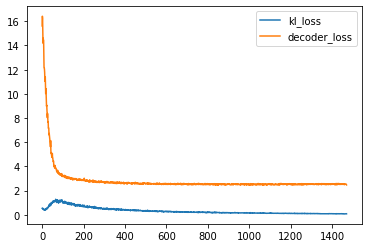

In [233]:
MultiVAEmodel_data_1 = run_MultiVAE_model_train(data_1_train, data_1_test)

In [0]:
def showSampleData(model, size, range=[-15, 15]):
  samples, mus = model.sample(size)

  mus = mus.detach().numpy()
  samples = samples.detach().numpy()

  traces = [
      go.Scatter(x=samples[:, 0], y=samples[:, 1], mode='markers', name='samples'),
      go.Scatter(x=mus[:, 0], y=mus[:, 1], mode='markers', name='mus')
  ]
  fig = go.Figure(data=traces, layout=go.Layout(width=700, height=700))  
  fig.update_xaxes(range=range)
  fig.update_yaxes(range=range)
  fig.update_traces(marker=dict(size=2))
  fig.show()

In [235]:
showSampleData(MultiVAEmodel_data_1, 1500)

After epoch 0 loss is 4.7470543887339485 and validation loss is 3.515537738800049
After epoch 1 loss is 3.25198364095623 and validation loss is 3.057074785232544
After epoch 2 loss is 2.93511599748313 and validation loss is 2.8525948524475098
After epoch 3 loss is 2.7879910323084616 and validation loss is 2.7295010089874268
After epoch 4 loss is 2.682503977600409 and validation loss is 2.6439309120178223
After epoch 5 loss is 2.6214035481822733 and validation loss is 2.605879068374634
After epoch 6 loss is 2.593731254136481 and validation loss is 2.58528208732605
After epoch 7 loss is 2.582125002024125 and validation loss is 2.5793421268463135
After epoch 8 loss is 2.580492386201612 and validation loss is 2.5806655883789062
After epoch 9 loss is 2.5780413394071617 and validation loss is 2.5780394077301025


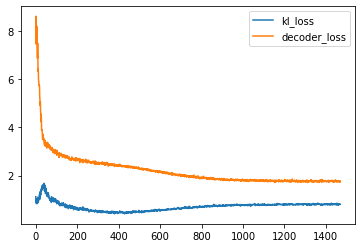

In [236]:
MultiVAEmodel_data_2 = run_MultiVAE_model_train(data_2_train, data_2_test)

In [237]:
showSampleData(MultiVAEmodel_data_2, 1500)

After epoch 0 loss is 8.83051213764009 and validation loss is 5.143735408782959
After epoch 1 loss is 4.479194675173078 and validation loss is 3.968900680541992
After epoch 2 loss is 3.6713773620371914 and validation loss is 3.4194142818450928
After epoch 3 loss is 3.2542139364748586 and validation loss is 3.1128337383270264
After epoch 4 loss is 3.04412951923552 and validation loss is 2.987783432006836
After epoch 5 loss is 2.9578239901536176 and validation loss is 2.936864137649536
After epoch 6 loss is 2.920370932339 and validation loss is 2.9088919162750244
After epoch 7 loss is 2.89969303494408 and validation loss is 2.8964591026306152
After epoch 8 loss is 2.8843292379054892 and validation loss is 2.8752281665802
After epoch 9 loss is 2.878988452509147 and validation loss is 2.8705477714538574


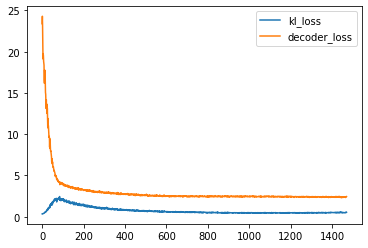

In [238]:
ScalarVAEmodel_data_1 = run_ScalarVAE_model_train(data_1_train, data_1_test)

In [239]:
showSampleData(ScalarVAEmodel_data_1, 1500)

After epoch 0 loss is 8.035579984690868 and validation loss is 3.7768654823303223
After epoch 1 loss is 3.3878590720040456 and validation loss is 3.1711628437042236
After epoch 2 loss is 3.0366696208512702 and validation loss is 2.952785015106201
After epoch 3 loss is 2.922485486179793 and validation loss is 2.9033944606781006
After epoch 4 loss is 2.889816310130009 and validation loss is 2.876837968826294
After epoch 5 loss is 2.8642979252095127 and validation loss is 2.859041690826416
After epoch 6 loss is 2.849304436015434 and validation loss is 2.8472917079925537
After epoch 7 loss is 2.8387410202804877 and validation loss is 2.83347487449646
After epoch 8 loss is 2.8339756524481743 and validation loss is 2.8248045444488525
After epoch 9 loss is 2.8310890700541385 and validation loss is 2.826326847076416


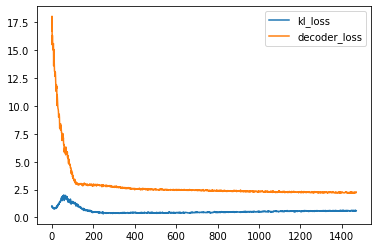

In [240]:
ScalarVAEmodel_data_2 = run_ScalarVAE_model_train(data_2_train, data_2_test)

In [241]:
showSampleData(ScalarVAEmodel_data_2, 1500)

After epoch 0 loss is 2.4715458438509987 and validation loss is 2.215165615081787
After epoch 1 loss is 2.1915862300769002 and validation loss is 2.168492555618286
After epoch 2 loss is 2.1412802115589584 and validation loss is 2.1035215854644775
After epoch 3 loss is 2.054851519007261 and validation loss is 1.9867578744888306
After epoch 4 loss is 1.9265461332943974 and validation loss is 1.8488786220550537
After epoch 5 loss is 1.8265453422961593 and validation loss is 1.7968984842300415
After epoch 6 loss is 1.7928963826627147 and validation loss is 1.7692275047302246
After epoch 7 loss is 1.7743202788489205 and validation loss is 1.7565315961837769
After epoch 8 loss is 1.7615633035192684 and validation loss is 1.7428534030914307
After epoch 9 loss is 1.7467345980559887 and validation loss is 1.7270344495773315


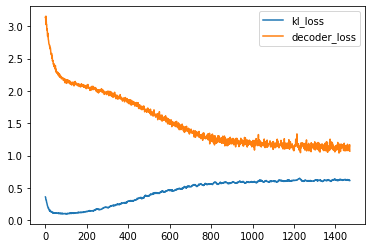

In [242]:
MultiVAEmodel_data_3 = run_MultiVAE_model_train(data_3_train, data_3_test)

In [246]:
showSampleData(MultiVAEmodel_data_3, 1500, range=[-4, 4])

After epoch 0 loss is 2.815833244193979 and validation loss is 2.33725905418396
After epoch 1 loss is 2.2542104023654446 and validation loss is 2.2056868076324463
After epoch 2 loss is 2.196893121109528 and validation loss is 2.1852266788482666
After epoch 3 loss is 2.1833962112867913 and validation loss is 2.1753618717193604
After epoch 4 loss is 2.1771143812711546 and validation loss is 2.1715548038482666
After epoch 5 loss is 2.1732209734365244 and validation loss is 2.168125629425049
After epoch 6 loss is 2.171427451023439 and validation loss is 2.167567253112793
After epoch 7 loss is 2.1699557434133934 and validation loss is 2.1663124561309814
After epoch 8 loss is 2.1692006377135815 and validation loss is 2.166219711303711
After epoch 9 loss is 2.169905441958888 and validation loss is 2.165409564971924


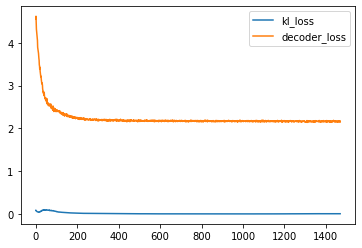

In [244]:
ScalarVAEmodel_data_3 = run_ScalarVAE_model_train(data_3_train, data_3_test)

In [245]:
showSampleData(ScalarVAEmodel_data_3, 1500, range=[-4, 4])